In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data import

In [ ]:
df = pd.read_csv('Data_Sources_csv.csv', sep = ';')

print('Dataset size', df.shape)

num_rows, num_feature = df.shape

print('row number: ', num_rows)
print('feature number: ', num_feature)
print()
print('names of features: ', list(df))

Dataset size (66460, 5)
row number:  66460
feature number:  5

names of features:  ['url', 'date', 'text', 'tag', 'source']


In [ ]:
df.head(5)

,url,date,text,tag,source
0,https://vk.com/club3291025?w=wall-3291025_1020782,2023-04-15 19:39,Всем добрый день! У меня БАР 2 типа. Начала ч...,БАР,ВК
1,https://vk.com/id32362343,2023-04-15 19:46,это на всякий случай?,БАР,ВК
2,https://vk.com/id415411329,2023-04-15 19:44,Попробуйте успокоиться. Сделайте выводы. Приго...,БАР,ВК
3,https://vk.com/id777797099,2023-04-15 19:44,На все вопросы вы ответили сами.,БАР,ВК
4,https://vk.com/id739587393,2023-04-15 19:47,"Всё к лучшему. Если вы так сделали, значит так...",БАР,ВК


# Lemmatization

In [ ]:
import io
f = io.open('stopwords-ru.txt','r',encoding='utf8')

sw = f.read()
sw = sw.split('\n')

In [ ]:
import string

def clean_tweet(tweet):
    temp = str(tweet)
    temp = temp.lower()
    temp = re.sub("#[A-Za-zА-Яа-я0-9_]+","", temp)
    temp = re.sub("@[A-Za-zА-Яа-я0-9_]+","", temp)
    temp = re.sub("\n"," ", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp =  re.sub('[^а-яё ]', '', temp, flags=re.IGNORECASE)
    temp = temp.split()
    temp = [w for w in temp if not w in sw]
    temp = " ".join(word for word in temp if len(word)>1)
    return temp

In [ ]:
pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 75.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=74fa13a49ebbbf03af6d361ea8840a51343bf0fd95b420182361989a33b98b3b
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()

def lemmatize(doc):
    tokens = []
    for token in doc.split():
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    tokens = " ".join(word for word in tokens if word not in sw)
    return tokens

In [ ]:
df['text'] = df['text'].apply(clean_tweet)
df['text'] = df['text'].apply(lemmatize)

In [ ]:
df.to_csv('df_lemma_2.csv', index = False)

# Balancing data

In [ ]:
import pandas as pd
import numpy as np
import random

In [ ]:
pip install ruwordnet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.1 MB/s eta 0:00:00
  Created wheel for ruwordnet: filename=ruwordnet-0.0.6-py3-none-any.whl size=13169 sha256=b9bd13d746b2ccdf680183822addc788d2d0eab5ee23b467079e6ff08cb42d68
  Stored in directory: /root/.cache/pip/wheels/6f/75/be/a338d987d811bbfe38a40a76166cc84dfdc88e02eadc3ff9c0
Successfully built ruwordnet
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.31
    Uninstalling SQLAlchemy-2.0.31:
      Successfully uninstalled SQLAlchemy-2.0.31
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.52 which is incompatible.


In [ ]:
df = pd.read_csv('df_lemma_2.csv')
df = df.iloc[:,1:]

#get rid of observations with NaN values and too short texts (1 word after removing stop words)
def word_count(text):
    return len(text.split())

df = df[df['text'].isna()==False]
df = df[df['text'].apply(word_count)>1]

### Function for augmentation through RuWordNet


In [ ]:
from ruwordnet import RuWordNet
wn = RuWordNet(filename_or_session='ruwordnet-2021.db')

In [ ]:
# function for replacement of a word with synonym
def get_synonym(word):
  if word != 'бар':
    try:
      synsets = wn.get_senses(word)[0].synset.hypernyms
      synonyms = set()
      for sense in synsets:
          synonyms.add(sense.title.lower())
      return random.choice(list(synonyms)) if synonyms else word
    except:
      return word
  else:
    return word

# function for augmentation
def augment_text(text, replace_prob = 0.8):
    words = text.split()
    new_words = [get_synonym(word) if random.random() < replace_prob else word for word in words]
    return ' '.join(new_words).replace('(', '').replace(',', '').replace(')', '')

### Application of a function on underpresented classes

In [ ]:
bar= df[df['tag'] == 'БАР']
okr= df[df['tag'] == 'ОКР']
prl= df[df['tag'] == 'ПРЛ']
dep= df[df['tag'] == 'депрессия']
#par= df[df['tag'] == 'паранойя']
trev= df[df['tag'] == 'тревожное р-во']
shiz= df[df['tag'] == 'шизофрения']

<BarContainer object of 6 artists>

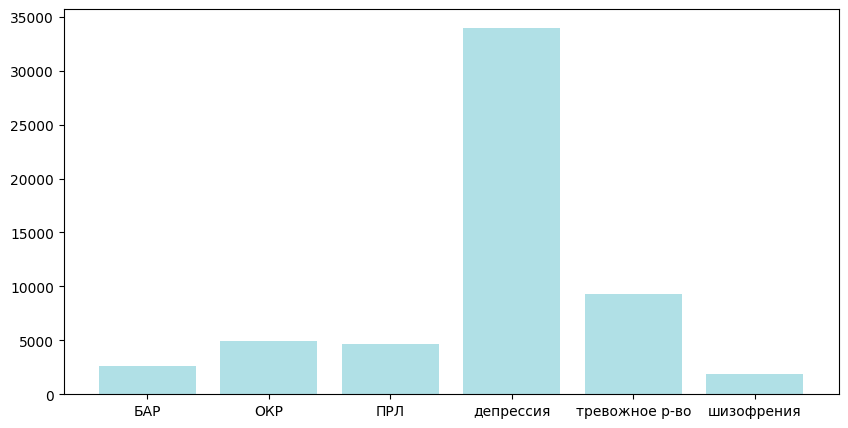

In [ ]:
df = df[df['tag'].isin(['БАР', 'ОКР', 'ПРЛ', 'депрессия', 'тревожное р-во', 'шизофрения'])]
tags = df.groupby('tag').size().reset_index()

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(tags['tag'], tags[0], color ='#B0E0E6',
        width = 0.8)

In [ ]:
from sklearn.utils import resample

dep = resample(dep, replace=True, n_samples=6000, random_state=1)

In [ ]:
okr_aug = okr
okr_aug['text'] = okr_aug['text'].apply(augment_text)

prl_aug = prl
prl_aug['text'] = prl_aug['text'].apply(augment_text)

bat_aug = bar
bat_aug['text'] = bat_aug['text'].apply(augment_text)

shiz_aug = shiz
shiz_aug['text'] = shiz_aug['text'].apply(augment_text)


In [ ]:
df_balanced = pd.concat([bar, okr, prl, dep, trev, shiz, prl_aug, shiz_aug, okr_aug, bat_aug])

<BarContainer object of 6 artists>

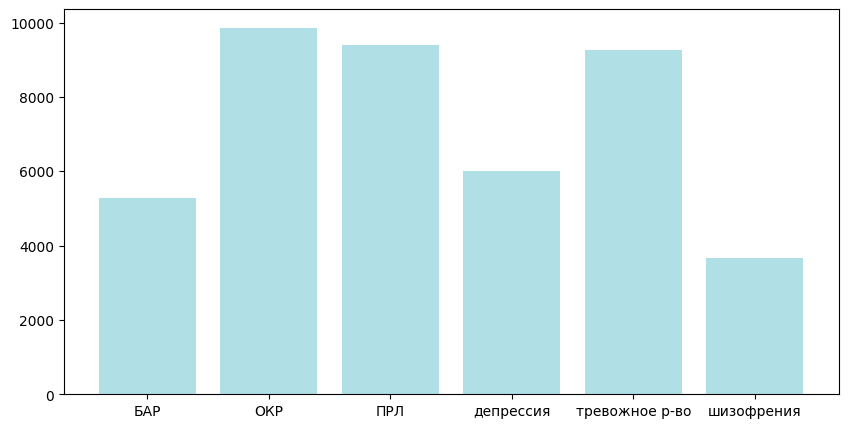

In [ ]:
import matplotlib.pyplot as plt

tags = df_balanced.groupby('tag').size().reset_index()

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(tags['tag'], tags[0], color ='#B0E0E6',
        width = 0.8)

In [ ]:
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

In [ ]:
df_balanced.to_csv('df_lemma_augmented_v1.csv')

# Preprocessing of data

In [ ]:
df_balanced = pd.read_csv('df_lemma_augmented_v1.csv')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_words= 10000

t = Tokenizer(filters='!#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')

t.fit_on_texts(df_balanced['text'])
word_index = t.word_index

sequences = t.texts_to_sequences(df_balanced['text'])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 30
padding_type='post'
trunc_type='post'

padded_seq = pad_sequences(sequences, maxlen=maxlen, padding=padding_type, truncating=trunc_type)
padded_seq

array([[ 794,  259,  260, ...,    0,    0,    0],
       [ 309, 1327, 1111, ...,    0,    0,    0],
       [4178, 4356, 4356, ...,  298,  304,  366],
       ...,
       [ 586,  123,  121, ...,    0,    0,    0],
       [ 687,  423, 2056, ...,    0,    0,    0],
       [1415,   92,   93, ...,   95,  181,  166]], dtype=int32)

In [ ]:
Y = pd.get_dummies(df_balanced['tag'])
Y.head(10)

,БАР,ОКР,ПРЛ,депрессия,тревожное р-во,шизофрения
0,True,False,False,False,False,False
1,False,False,False,False,True,False
2,False,False,True,False,False,False
3,False,False,False,True,False,False
4,False,False,False,True,False,False
5,False,False,False,False,True,False
6,False,True,False,False,False,False
7,False,False,False,False,True,False
8,False,True,False,False,False,False
9,False,False,False,True,False,False


In [ ]:
from sklearn.model_selection import train_test_split
# divide the data into a test collection and a training collection
x_train, x_valid, y_train, y_valid = train_test_split(padded_seq, Y, test_size=0.2, stratify = Y)
print('x_train: ', x_train.shape)
print('x_valid: ', x_valid.shape)
print('------------------------------')
print('y_train: ' , y_train.shape)
print('y_valid: ' , y_valid.shape)

x_train:  (34791, 30)
x_valid:  (8698, 30)
------------------------------
y_train:  (34791, 6)
y_valid:  (8698, 6)


# Embedding layer

In [ ]:
pip install navec

In [ ]:
from navec import Navec

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
# leaving only words which are presented in a dictionary
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
j=0

for word, i in word_index.items():
    embedding_vector = navec.get(word)
    #print(embedding_vector)
    if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Model compilation

In [ ]:
# build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D, Activation, GlobalMaxPool1D, LSTM, MaxPooling1D
from tensorflow.keras import layers

embedding_dim = 300

model = Sequential()
# embedding layer
model.add(Embedding(len(word_index) + 1, embedding_dim, input_length=maxlen))
# convolutional layer
model.add(Conv1D(128, 3, activation="relu"))
# pulling
model.add(GlobalMaxPool1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.7))
# output
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 30, 300)           14625900  
                                                                 
 conv1d_15 (Conv1D)          (None, 28, 128)           115328    
                                                                 
 global_max_pooling1d_15 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 6)                 390       
                                                     

In [ ]:
# load coefficients of embedings to layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False # False - means that the layer is frozen

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Model training

In [ ]:
import time
s1 = time.time()
my_epox = 15
history = model.fit(x_train, y_train, epochs=my_epox, batch_size=64, validation_data=(x_valid, y_valid))
s2 = time.time()
print('Время обучения сети: ', s2-s1)

Epoch 1/15
544/544 [==============================] - 7s 11ms/step - loss: 1.0903 - accuracy: 0.4723 - val_loss: 0.7817 - val_accuracy: 0.5912
Epoch 2/15
544/544 [==============================] - 4s 7ms/step - loss: 0.8289 - accuracy: 0.5605 - val_loss: 0.7277 - val_accuracy: 0.5911
Epoch 3/15
544/544 [==============================] - 4s 7ms/step - loss: 0.7493 - accuracy: 0.5981 - val_loss: 0.6868 - val_accuracy: 0.6339
Epoch 4/15
544/544 [==============================] - 6s 12ms/step - loss: 0.7024 - accuracy: 0.6265 - val_loss: 0.6459 - val_accuracy: 0.6573
Epoch 5/15
544/544 [==============================] - 5s 9ms/step - loss: 0.6626 - accuracy: 0.6552 - val_loss: 0.6263 - val_accuracy: 0.6781
Epoch 6/15
544/544 [==============================] - 4s 6ms/step - loss: 0.6265 - accuracy: 0.6802 - val_loss: 0.6239 - val_accuracy: 0.6829
Epoch 7/15
544/544 [==============================] - 3s 5ms/step - loss: 0.5946 - accuracy: 0.7014 - val_loss: 0.6305 - val_accuracy: 0.7021
Epoc

# Validation

In [ ]:
#predictions
predictions = model.predict(x_valid)

#  number of estimates and size of estimates in the prediction
print(predictions.shape)
print(predictions)

272/272 [==============================] - 1s 2ms/step
(8698, 6)
[[1.9171763e-08 9.7754842e-01 2.2451565e-02 4.7837724e-14 3.5304272e-15
  4.0431821e-21]
 [3.5539446e-07 3.0267692e-01 6.9732273e-01 6.3541329e-14 5.5797155e-12
  5.1342824e-18]
 [0.0000000e+00 0.0000000e+00 6.3358451e-35 5.3338843e-23 1.0000000e+00
  0.0000000e+00]
 ...
 [1.5951421e-06 6.4465499e-01 3.5534337e-01 8.6974610e-20 3.1678976e-18
  1.4471347e-20]
 [1.4603407e-19 2.3294626e-09 5.7932088e-13 9.0752310e-01 9.2476904e-02
  2.6478985e-19]
 [2.3729879e-07 2.9996213e-01 7.0003766e-01 9.6683153e-18 7.2874000e-18
  2.7982228e-21]]


In [ ]:

y_preds = np.argmax(predictions, axis=1).tolist()

for i in range(len(y_preds)):
    if y_preds[i]==0: y_preds[i]='БАР'
    if y_preds[i]==1: y_preds[i]='ОКР'
    if y_preds[i]==2: y_preds[i]='ПРЛ'
    if y_preds[i]==3: y_preds[i]='депрессия'
    if y_preds[i]==4: y_preds[i]='тревожное р-во'
    if y_preds[i]==5: y_preds[i]='шизофрения'

In [ ]:
yy = y_valid.idxmax(axis=1)

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
print(metrics.classification_report(y_preds, yy))

                precision    recall  f1-score   support

           БАР       0.77      0.83      0.80       979
           ОКР       0.81      0.79      0.80      2028
           ПРЛ       0.78      0.78      0.78      1877
     депрессия       0.73      0.65      0.69      1345
тревожное р-во       0.74      0.81      0.78      1699
    шизофрения       0.78      0.74      0.76       770

      accuracy                           0.77      8698
     macro avg       0.77      0.77      0.77      8698
  weighted avg       0.77      0.77      0.77      8698



In [ ]:
import pickle

with open('CNN_best.pkl','wb') as f:
    pickle.dump(model,f)